# Simple FEM for one dimensional Burgers' equation

The problem for $u(t,x)$ is stated as
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0 \quad \text{for} \quad x \in [-1,1] , t \in [0, 0.5]
$$
with $\nu=\frac{0.01}{\pi}$ subject to the boundary condition
$$
u(t, x=0) = 0
$$
and the initial condition
$$
u(t=0, x) = -\sin(\pi x)
$$

The problem is inspired by https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace
 
ns = Namespace()
ns.nu = 0.01 / np.pi

# Create topology (connectivity of mesh) and geometry (position of mesh)
N = 55
topo, geom = mesh.rectilinear([np.linspace(-1, 1, N)])

# Define the geometry variable as well as gradients, normal and jacobians on the domain.
ns.x = geom
ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
# Define basis
ns.basis = topo.basis('std', degree=2)

## Problem formulation

The weak form of the equation to be solved is 

$$ 
 \int_\Omega \frac{\partial u}{\partial t} v dV + \int_\Omega u\nabla u v dV + \nu \int_\Omega  \nabla u \cdot \nabla v dV = 0.
$$

The Dirichlet boundary conditions are expressed as 

$$ 
 \underset{u}{\min} \int_{\partial\Omega_D} u^2 dS = 0.
$$

In [6]:
# The solution function to evaluate results is a dot product of the argument 'uh' with the basis)
ns.u = function.dotarg('lhs', ns.basis)

# By linearity the test function v can be replaced by the basis that spans its space. 
residual = topo.integral('nu ∇_i(u) ∇_i(basis_n)  dV' @ ns, degree=2)
# The gradient adds a new axis, which is removed in this 1D case by taking [0]
residual += topo.integral('u ∇_i(u) basis_n dV' @ ns, degree=2)[0]

# By linearity the test function v can be replaced by the basis that spans its space.
inertia = topo.integral('u basis_n dV' @ ns, degree=2)

# Dirichlet boundary condition
sqr = topo.boundary['left,right'].integral('u^2 dS' @ ns, degree=2)
constrain = solver.optimize('lhs', sqr, droptol=1e-15)

# Initial conditions
x0 = np.linspace(-1, 1, 2*N-1)
lhs0 = -np.sin(np.pi*x0)

# Solve the system
dt = 1e-4
lhsiter = iter(solver.cranknicolson('lhs', residual=residual, inertia=inertia, timestep=dt, lhs0=lhs0, constrain=constrain))

optimize > constrained 2/109 dofs
optimize > optimum value 0.00e+00


## Prepare visualization
This code defines a python function `plot_line` to plot a *nutils* function (e.g. basis or solution variables) on the domain  $x \in [0, 1]$

In [7]:
bezier = topo.sample('bezier', 32)
nanjoin = lambda array, tri: np.insert(array.take(tri.flat, 0).astype(float), slice(tri.shape[1], tri.size, tri.shape[1]), np.nan, axis=0)
sampled_x = nanjoin(bezier.eval('x_0' @ ns), bezier.tri)
def plot_line(func, **arguments):
  plt.plot(sampled_x, nanjoin(bezier.eval(func, **arguments), bezier.tri))
  plt.xlabel('x_0')
  plt.xticks(np.linspace(-1, 1, 5))

## Integrate in time

newton 0% > solve > solving 107 dof system to tolerance 2e-04 using arnoldi solver
newton 0% > solve > solver returned with residual 8e-17
newton 0% > estimated residual minimum at 100% of update vector
newton 0% > update accepted at relaxation 1.0
newton 71% > solve > solving 107 dof system to tolerance 5e-11 using arnoldi solver
newton 71% > solve > solver returned with residual 5e-22
newton 71% > estimated residual minimum at 100% of update vector
newton 71% > update accepted at relaxation 1
newton 100% > converged in 2 steps to residual 1.4e-13
newton 0% > solve > solving 107 dof system to tolerance 2e-04 using arnoldi solver
newton 0% > solve > solver returned with residual 2e-17
newton 0% > estimated residual minimum at 100% of update vector
newton 0% > update accepted at relaxation 1.0
newton 81% > solve > solving 107 dof system to tolerance 6e-12 using arnoldi solver
newton 81% > solve > solver returned with residual 4e-23
newton 81% > estimated residual minimum at 100% of upda

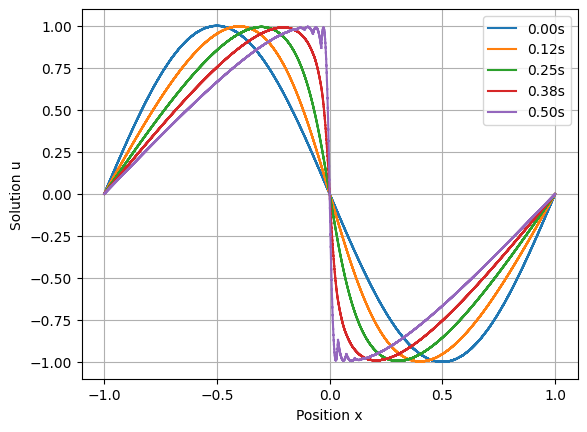

In [8]:
results = [lhs0]
for i in range(1, int(0.5/dt)):
    res = next(lhsiter)
    if i%1000 == 0:
        results.append(res)

for res in results:
    plot_line(ns.u, lhs=res)
plt.legend([f"{t:.2f}s" for t in np.linspace(0, 0.5, 5) ])
plt.xlabel("Position x")
plt.ylabel("Solution u")
plt.grid()
